# Udacity Machine Learning Engineer Nanodegree

- _Project from the Kaggle competition: [Jigsaw unintended bias in toxicity classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview)_
- _Field: Natural Language Processing_<br/>


# Definition

## Project Overview

<span class="rubric done">Student provides a high-level overview of the project in layman's terms. Background information such as the problem domain, the project origin, and related data sets or input data is given.</span>

Natural Language Processing is a complex field which is hypothesised to be part of AI-complete set of problems, implying that the difficulty of these computational problems is equivalent to that of solving the central artificial intelligence problem making computers as intelligent as people. <cite data-cite="AiComplete"></cite>
With over 90% of data ever generated being produced in the last 2 years <cite data-cite="ScienceDaily1"></cite> and with a great proportion being human generated unstructured text there is an ever increasing need to advance the field of Natural Language Processing.

Recent UK Government proposal to have measures to regulate social media companies over harmful content, including "substantial" fines and the ability to block services that do not stick to the rules is an example of the regulamentory need to better manage the content that is being generated by users. <cite data-cite="BBCSocialMedia"></cite> 

Other initiatives like <a href="https://www.riotgames.com/en">Riot Games</a>'s work aimed to predict and reform toxic player behaviour during games <cite data-cite="ArsRiotGame"></cite> is another example of this effort to understand the content being generated by users and moderate toxic content.

However, as highlighted by the Kaggle competition [Jigsaw unintended bias in toxicity classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview), existing models suffer from unintended bias where models might predict high likelihood of toxicity for content containing certain words (e.g. "gay") even when those comments were not actually toxic (such as "I am a gay woman"), leaving  machine only classification models still sub-standard.

Having tools that are able to flag up toxic content without suffering from unintended bias is of paramount importance to preserve Internet's fairness and freedom of speech.


## Problem Statement

<span class="rubric done">The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.</span>

From [Kaggle competition page](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview) :

_The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion._

_Last year, in the Toxic Comment Classification Challenge, participants built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations._

_Here's the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users._

_In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations._

### Strategy

A Deep Neural network containing a combination of LSTM units and Linear Layers which trains on both the target label and subgroups and identities. 

LSTM are particularly powerful when it comes to model sequences, the human language is a perfect candidate.

LSTMs are a special type of RNN able to build and retain an internal state (cell memory) that can be passed across different time steps. This is very useful in natural language modeling because of the relationship that words have and how this affects their meaning.


## Metrics

<span class="done rubric">Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.<span>

This competition uses a newly developed metric that combines several submetrics to balance overall performance with various aspects of unintended bias.

Please refer to [evaluation section](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation) of the competition and the provided [benchmark kernel](https://www.kaggle.com/dborkan/benchmark-kernel) with code to calculate the competition evaluation metrics.

Here are defined the submetrics:

### Overall AUC
This is the ROC-AUC for the full evaluation set.


### Bias AUCs

To measure unintended bias, we again calculate the ROC-AUC, this time on three specific subsets of the test set for each identity, each capturing a different aspect of unintended bias. You can learn more about these metrics in Conversation AI's recent paper *[Nuanced Metrics for Measuring Unintended Bias with Real Data in Text Classification](https://arxiv.org/abs/1903.04561)*. <cite data-cite="1903.04561"></cite>

**Subgroup AUC:** Here, we restrict the data set to only the examples that mention the specific identity subgroup. *A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity*.

**BPSN (Background Positive, Subgroup Negative) AUC:** Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. *A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not*, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

**BNSP (Background Negative, Subgroup Positive) AUC:** Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. *A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not*, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.

### Generalized Mean of Bias AUCs

To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:


$M_p(m_s)=( \frac{1}{N} \sum_{s=1}^{N}m_{s}^{p} )^{\frac{1}{p}}$

where:

- $M_p$ = the $p^{th}$ power-mean function
- $m_s$ = the bias metric mm calculated for subgroup $s$
- $N$ = number of identity subgroups

For this competition, we use a $p$ value of -5 to encourage competitors to improve the model for the identity subgroups with the lowest model performance.

### Final Metric

We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

$score=w_0AUC_{overall}+\sum_{a=1}^{A}w_aM_p(m_{s,a})$

where:

- $A$ = number of submetrics (3)
- $m_{s,a}$ = bias metric for identity subgroup ss using submetric $a$
- $w_a$ = a weighting for the relative importance of each submetric; all four $w$ values set to 0.25

While the leaderboard will be determined by this single number, we highly recommend looking at the individual submetric results, [as shown in this kernel](https://www.kaggle.com/dborkan/benchmark-kernel), to guide you as you develop your models.

# Analysis

## Data Exploration

<span class="rubric done">If a dataset is present, features and calculated statistics relevant to the problem have been reported and discussed, along with a sampling of the data. In lieu of a dataset, a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.<span>

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

train_path = './input/jigsaw-unintended-bias-in-toxicity-classification/train.csv'
test_path = './input/jigsaw-unintended-bias-in-toxicity-classification/test.csv'


In [108]:
# Making sure that analysis is reproducible
from notebooks.library.Reproducibility \
    import *

Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()

In [109]:
# Loading train and test data
from notebooks.library.ExploratoryAnalysis \
    import ExploratoryAnalysis, JigsawExploratoryAnalysis

explore = JigsawExploratoryAnalysis(train_path = train_path, test_path= test_path)

### Train and test stats

Below are some of the train and test datasets statistics.

We have a little short of 2 million comments in our training set and short of 100 thousands comments in the test set, that is 5.4% of the training data.

Furthermore 5.9% of comments in the training set are considered _toxic_.

Here a _toxic_ comment is considered a comment whose toxicity score is greater than 0.5 in a range between 0-1

In [110]:
test_percent, toxic_comment_distribution = explore.calculate_stats()

print("The train set contains {:,} number of samples"\
      .format(len(explore.train)))
print("The test set contains {:,} number of samples"\
      .format(len(explore.test)))
print("The test set is {0:.1f}% of the training set"\
      .format(test_percent * 100))
print("The test set contains {:,} toxic comment"\
      .format(explore.train['toxic'].sum().sum()))
print("Toxic comments are {0:.1f}% of the total comments"\
      .format(toxic_comment_distribution * 100))

The train set contains 1,804,874 number of samples
The test set contains 97,320 number of samples
The test set is 5.4% of the training set
The test set contains 106,438 toxic comment
Toxic comments are 5.9% of the total comments


### Toxicity score distribution

Since the toxicity score is a continuous variable within the range 0-1, it is interesting to observe the distribution of the score among the training set.

We can see that highly toxic score are quite rare, and most of the comments that have been given a toxicity greater than 0 still lie below the 0.5 threshold.

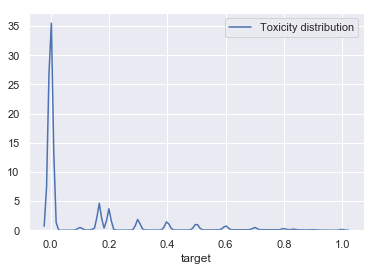

In [12]:
sns.distplot(explore.train['target'], \
             hist=False, kde=True, label="Toxicity distribution")

### Distribution of toxic/non-toxic in the training set divided per identity


We are interested to improve the toxicity classification within each identity group, as some group carry some unintended bias.

We can see below some stats regarding:

- the number of comments (`count`) within each group (`indentity`) 
- the number of toxic comment (`toxic_count`) within each group
- the percentage of toxic_comment within each group (`toxic_percent`)
- the number of null values (`na_count`) contained within each group


In [13]:
toxic_stats = explore.calculate_toxic_stats_for_identities(threshold=0.5)    
toxic_stats.sort_values(['toxic_percent', 'count'], axis=0, ascending=False)


,identity,toxic_count,count,toxic_percent,na_count
6,black,3079,13869,0.222006,0
2,homosexual_gay_or_lesbian,2005,10233,0.195935,0
7,white,4660,23852,0.195371,0
8,psychiatric_or_mental_illness,628,4077,0.154035,0
5,muslim,2974,19666,0.151225,0
4,jewish,763,7239,0.105401,0
0,male,4187,40036,0.104581,0
1,female,4689,50548,0.092763,0
3,christian,2099,35507,0.059115,0


#### Distribution of the percentage of toxic comments per identity group

The table above is sorted by the percentage of toxic comments then by the overall number of documents within the identity group.

From above, we can see that the identity group `black` has the highest number of toxic comments, closely followed by `homosexual_gay_or_lesbian` and `white`.

By plotting the distribution of the percentage of toxic comments per group (below) we can see that it follows a normal distribution and that some identities like `black` is around +1 standard deviation from the mean, other groups like `christian` is around -1 standard deviation from the mean.

This confirms how for certain identity groups there is a much higher incidence of toxic comments.

#### Percentage of toxic comments per group

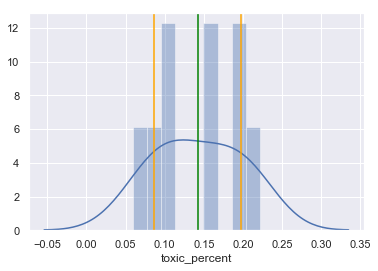

In [14]:
t_percent = toxic_stats['toxic_percent']
sns.distplot(t_percent, bins = 9)
plt.axvline(t_percent.mean(), 0,12, color = 'green')
plt.axvline(t_percent.mean() - t_percent.std(), 0,12, color= 'orange')
plt.axvline(t_percent.mean() + t_percent.std(), 0,12, color= 'orange')

In [111]:
no_identity_train, identity_train = explore.calculate_no_identity_stats()

In [112]:
no_identity_toxic_count = len(no_identity_train[(no_identity_train['toxic'] > 0)])
no_identity_count = len(no_identity_train)
no_identity_toxic_percent = no_identity_toxic_count / no_identity_count
identity_count = len(identity_train)
assert(identity_count  + no_identity_count == len(explore.train))

### Statistics of samples having no identity been set

From the statistics printed below it can be seen that only 11.65% of the training samples have been labelled with an identity.

In [113]:
print("The number of samples with no identity is {:,}"\
      .format(no_identity_count))
print("The number of samples with no identity that are toxic is {:,}"\
      .format(no_identity_toxic_count))
print("The percentage of samples with no identity that are toxic is {0:.2f}% "\
      .format(no_identity_toxic_percent * 100))
print("The number of samples with one or more identities being set is {:,}"\
      .format(identity_count))
print("The percentage of samples with one or more identities being set is {0:.2f}%"\
      .format(identity_count/len(explore.train) * 100))


The number of samples with no identity is 1,594,682
The number of samples with no identity that are toxic is 84,154
The percentage of samples with no identity that are toxic is 5.28% 
The number of samples with one or more identities being set is 210,192
The percentage of samples with one or more identities being set is 11.65%


### Distribution of toxic /non-toxic comments in subgroups

We can see below some statistics regarding toxic/non-toxic comments in each subgroup:

- the number of comments (`count`) within each (`subgroup`) 
- the number of toxic comment (`toxic_count`) within each subgroup
- the percentage of toxic_comment within each subgroup (`toxic_percent`)
- the number of null values (`na_count`) contained within each subgroup

In [20]:
toxic_subgroup_stats = explore.calculate_toxic_stats_for_subgroups(0.5)
toxic_subgroup_stats

,subgroup,toxic_count,count,toxic_percent,na_count
0,severe_toxicity,8,8,1.000000,0
1,obscene,7494,7648,0.979864,0
2,threat,2707,2793,0.969209,0
3,insult,78125,79887,0.977944,0
4,identity_attack,7094,7633,0.929386,0
5,sexual_explicit,2762,3119,0.885540,0


### No evident correlation between identities

The plot below shows that there is no evidence of correlation between the different identities identities

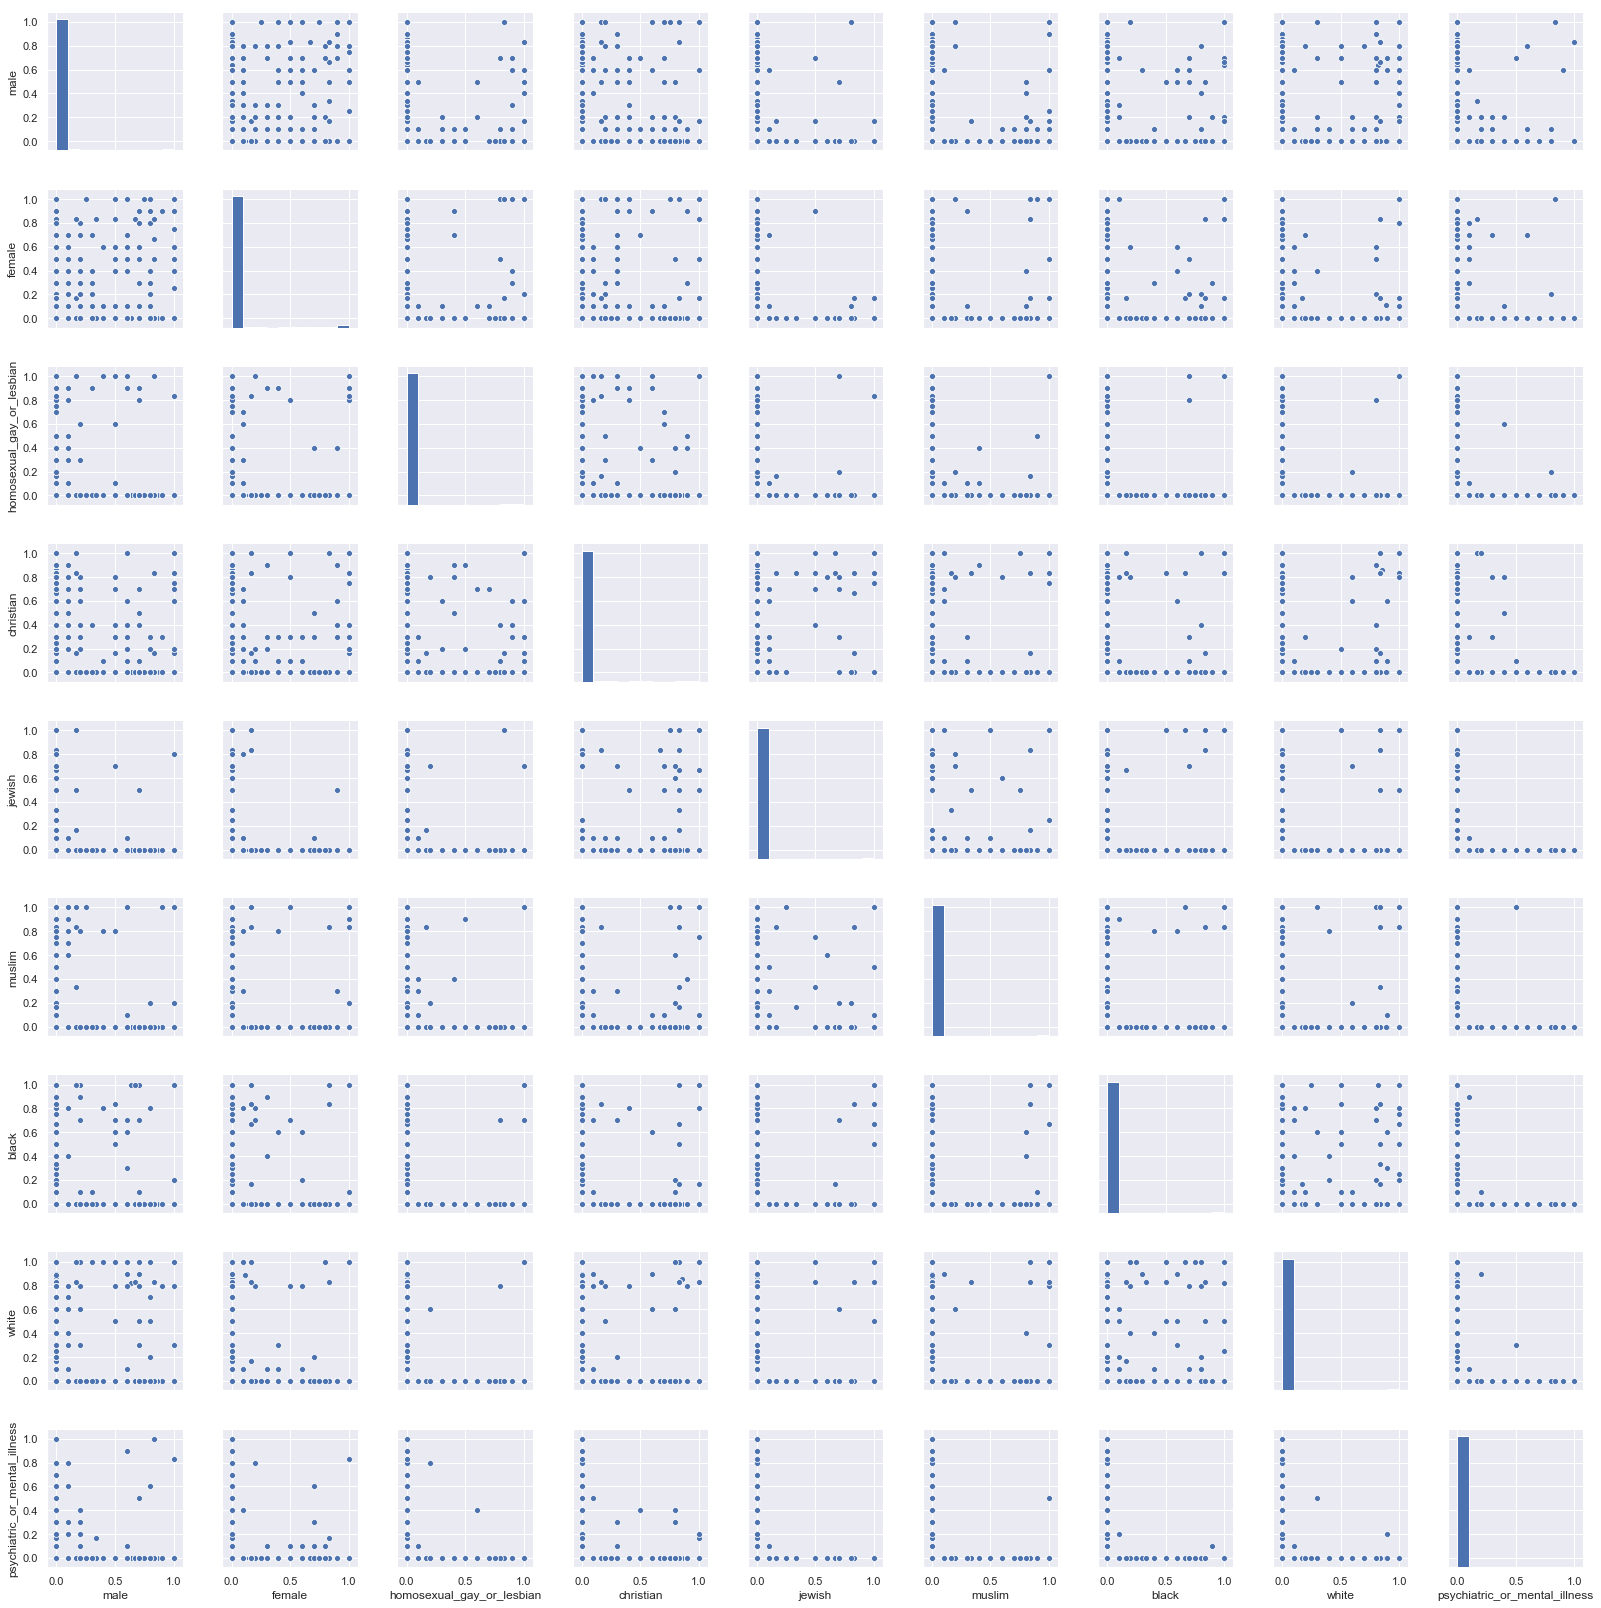

In [23]:
sns.pairplot(explore.train[JigsawExploratoryAnalysis.identity_columns].sample(10000))

### Exploring some toxic comments with special characters

It is common in NLP to remove from the corpus punctuations, very common words and special characters as generally those don't contribute to the overall meaning of the sentence.

However in some toxic comments, special characters are used to camouflage swear or offensive words to circumvent the filtering mechanism that are in place on most social platforms.

Below are some of those camouflaged words.

In [24]:
special_char_toxic = explore.train[\
                                   (explore.train.comment_text.str.contains(r'\w{0,}[\%\@\&$\#\*]{2,}\w{0,}')) \
                                   & (explore.train.toxic == 1)]

In [25]:
import re
camouflage_regex = re.compile(r'\w{0,}[\%\@\&$\#\*]{2,}\w{0,}')                              
camouflaged_words = [camouflage_regex.search(comm).group(0) for comm in special_char_toxic.comment_text]

In [26]:
random.sample(camouflaged_words, 7)

['f****', 'a$$', 'a**', 'f**k', '$$', 's**t', 'a$$']

### Comments lengths

Below it is plotted the distribution of the `comment_text` length across a sample of 10000 message. 
This statistic is useful for choosing the maximum comment length to which we will be cropping the text before using it in the training.

From the distribution below we see that the majority of comments are less than 100 words long, however there is still a significant number of comments that have between 100 and 200 words.

In [27]:
from notebooks.library.ObsceneTextPreprocessor \
    import ObsceneTextPreprocessor

processor = ObsceneTextPreprocessor()

In [28]:
sample = explore.train['comment_text'].sample(10000)
document_lengths = [len(processor.clean_doc(doc)) for doc in sample]
percentiles = np.percentile(document_lengths, [25, 50, 75, 95, 100])

In [29]:
print("95% of comments are {0:.0f} words or less".format(percentiles[3]))

95% of comments are 163 words or less


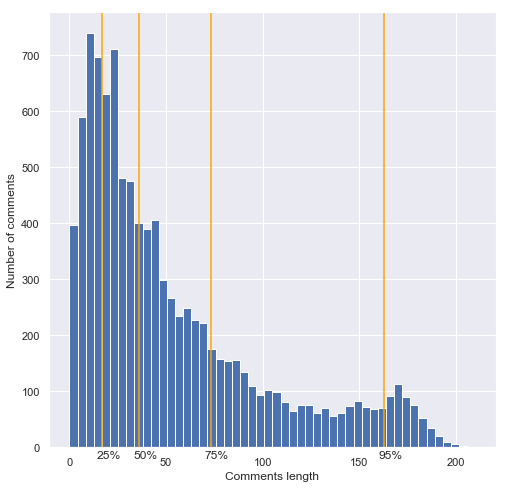

In [30]:
fig = plt.figure(figsize=(8, 8)) 
plt.xlabel('Comments length')
plt.ylabel('Number of comments')
plt.hist(document_lengths, bins=50)
plt.axvline(percentiles[0], 0,700, color = 'orange')
plt.annotate('25%', xy=(percentiles[0], 700), xytext=(percentiles[0]-3, -20))
plt.axvline(percentiles[1], 0,700, color = 'orange')
plt.annotate('50%', xy=(percentiles[1], 700), xytext=(percentiles[1]-3, -20))
plt.axvline(percentiles[2], 0,700, color = 'orange')
plt.annotate('75%', xy=(percentiles[2], 700), xytext=(percentiles[2]-3, -20))
plt.axvline(percentiles[3], 0,700, color = 'orange')
plt.annotate('95%', xy=(percentiles[3], 700), xytext=(percentiles[3]-3, -20))

plt.show()

### Dictionary exploration

Below are statistics regarding the number of words in the cleaned corpus and the size of the derived dictionary.

In [31]:
clean_comments = processor.clean(explore.train['comment_text'])

In [32]:
from notebooks.library.TextTokenizer \
    import TextTokenizer

Using TensorFlow backend.


In [34]:
tokenizer = TextTokenizer(clean_comments, [])
(_, all_words_count, unique_words_count) = tokenizer.get_stats()

In [35]:
print('There are are a total of {} words in the cleaned corpus.'.format(all_words_count))
print('The dictionary contains {} words.'.format(unique_words_count))

There are are a total of 95503548 words in the cleaned corpus.
The dictionary contains 460165 words.


## Algorithms and Techniques

<span class="rubric done"> Algorithms and techniques used in the project are thoroughly discussed and properly justified based on the characteristics of the problem.</span>

### Choice of deep learning framework

CuDNN's implementation of GRU and LSTM do not run deterministically in _Tensorflow_ and _Keras_ and the only way to deal with reproducible result is to [rerun the experiment](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/73341) 10 - 15 times and average the scores to get the progress of the model.

This becomes quite challenging when training a model takes hours and there is no time to rerun all experiments several times.

I have therefore chosen to use _PyTorch_ because it can be initialised to run in deterministic mode.


### Toxicity classification with LSTM

Sequence models like RNN have transformed speech recognition, DNA sequencing and natural language processing and other areas where the input is a sequence of various length and where different elements of the sequence share common features.

RNNs therefore are particularly suited to model the natural language, they are able to pass to subsequent steps features captured in previous steps.


### Long Short-Term Memory


A special form of RNN is the Long Short-Term Memory (LSTM) architecture.  <cite data-cite="lstm.paper"></cite>

LSTM are able to _remember_ also features extracted several time steps before by employing a series of _gates_ in control of what to remember and what to forget from previous time steps.

Furthermore, they overcome two common problems of basic RNN architectures, [vanishing and 
exploding gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).


### LSTM architecture

There are multiple articles that explain how LSTM work, one of the best resources is Christopher Olah's [blog post]( https://colah.github.io/posts/2015-08-Understanding-LSTMs/) with various diagrams how the LSTM units.

However, having followed Andrew Ng's [lecture](https://www.youtube.com/watch?v=5wh4HWWfZIY&list=PL1w8k37X_6L_s4ncq-swTBvKDWnRSrinI&index=11) on LSTM I find the mathematical formulas much more exhaustive.

Let's suppose we have the following sequence as input $x$ = "the fox jumped over the lazy dog"

In the above sentence, $x^{<1>}$ represents the word _'the'_, $x^{<2>}$ represents the word _'fox'_, $x^{<3>}$ represent the word _'jumped'_, and so forth up to $x^{<7>}$ which represents the word _'dog'_. 

More generally we can say that $x^{<t>}$ represent a word in a sequence at time step $t$.

An LSTM unit, at time step _t_ takes 3 key inputs:

- $x^{<t>}$ - the segment at time step _t_
- $c^{<t-1>}$ - the cell memory at the previous time step _(t - 1)_
- $a^{<t-1>}$ - the cell activation at the previous time step _(t - 1)_

The LSTM unit calculates:

- $\tilde{c}^{<t>} = \tanh(W_c[a^{<t-1>}, x^{<t>}] + b_c)$ - a new memory state candidate of time step _t_
- $\Gamma_u = \sigma(W_u[a^{<t-1>}, x^{<t>}] + b_u)$ - the update gate, it determines how much of the new memory state candidate should be used
- $\Gamma_f = \sigma(W_f[a^{<t-1>}, x^{<t>}] + b_f)$ - the forget gate, it determines how much of the received memory state should be retained
- $\Gamma_o = \sigma(W_o[a^{<t-1>}, x^{<t>}] + b_o)$ - the output gate, it calculates the activation output
- $c^{<t>} = \Gamma_u * \tilde{c}^{<t>} + \Gamma_f * c^{<t-1>}$ - it calculates how much of $\tilde{c}^{<t>}$ and $c^{<t-1>}$ will be retained in to the new memory state
- $a^{<t>} = \Gamma_o * \tanh({c}^{<t>})$ - it calculates the activation at time step _t_
- $y^{<t>} = softmax(a^{<t>})$ - the prediction y

The LSTM unit outputs the followings, those will be the input of the the LSTM unit at time step _(t + 1)_:
- $c^{<t>}$
- $a^{<t>}$
- $y^{<t>}$

In this architecture, the state (memory) of previous time steps is propagated to further steps, the update and forget gates determine how much of the received state is retained and how much of newly created state is added to the memory. 

A variation to this architecture are bidirectional LSTMs, these calculate their prediction not only based on previous time steps but also based on subsequent time steps. This feature  is particularly useful when subsequent elements of a sequence contribute in determining the features of the element at time step _t_.  

##### Use of LSTM for the Jigsaw problem

LSTM are very powerful in creating a language models that can learn the relationship between words, how the context of a sequence of words adds a different meaning to its word if the same words were taken in isolation. 

LSTMs are therefore particularly suited in identifying toxic comments not based on the presence/absence of individual words but rather on how these words act together to convey their meaning.

## Benchmark

<span class="rubric done">
Student clearly defines a benchmark result or threshold for comparing performances of solutions obtained.
</span>

As any other Kaggle competition, submissions are benchmarked against the test set held by Jigsaw producing a score as per the _Evaluation metrics_ defined below.

Submissions to this competition must be made through Kernels, also the following conditions must be met:

-   CPU Kernel <= 9 hours run-time
-   GPU Kernel <= 2 hours run-time
-   No internet access enabled
-   External data, freely & publicly available, is allowed, including pre-trained models
-   No custom packages enabled in kernels
-   Submission file must be named "submission.csv"


The [Kaggle Completition Leaderboard](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/leaderboard) provides a benchmark kernel against which I'm measuring my score.

- **Benchmark Kernel** with a score of 0.88224


# Methodology


## Data Preprocessing

<span class="rubric done">
    All preprocessing steps have been clearly documented. Abnormalities or characteristics about the data or input that needed to be addressed have been corrected. If no data preprocessing is necessary, it has been clearly justified.
</span>

### Obscene Text Preprocessor

As discussed earlier on in the _Data exploration_ section, it is common in NLP to remove from the corpus punctuations, very common words and special characters as generally those don't contribute to the overall meaning of the sentence. However when dealing with toxic comments, special characters are used to camouflage swear or offensive words to circumvent the filtering mechanism that are in place on most social platforms.

The `ObsceneTextProcessor` class tries to identify those words that are using punctuation to camouflage offensive words and replaces it with a sample swear word that is present in the `embeddings` dictionary.

Also, from exploration of comments that are highly toxic, it seems the authors tend to be very 'opinionated' about other individuals while generally bragging about themselves. I have therefore decided to leave these [personal pronouns](https://en.wikipedia.org/wiki/Personal_pronoun) which are generally removed during tokenisation because are considered [stop words](https://en.wikipedia.org/wiki/Stop_words)


### Tokenisation

One of the very first steps in building a language model is tokenisation, that is transforming a corpus of text into a dictionary of its components words, generally referred to as tokens.

Once a dictionary is built, we can represents each word that is encountered in numerical terms. There are two main approaches to represent a word, a _one-hot-encoding_ approach turns a word into a binary vector of the length of the dictionary where it contains all zeros except for a one at the index position of the word in the dictionary, this works well with small dictionaries. 

A second approach is to represent a word by its index in the dictionary, this turns a sentence into a vector of dictionary indices making word representation more memory efficient.

Because we are dealing with a large corpus of over 95 million words and a dictionary of nearly half a million words, _one-hot-encoding_ is not appropriate.

#### Padding sentences

When representing sentences as a sequence of indices, it is common to standardise the length of the samples by means of adding padding to shorter sentences or clipping longer sentences.

In the choice of padding I have used the statistics gathered in the exploratory analysis phase, this shows that the  distribution of sentences lengths, 95% of comments are 163 words or less and 99% of sentences are less than 200 words. Having benchmarked some predictions on various clipping lengths, I will be capturing 99% of words, setting the clipping/padding to 200 words. 


### Embeddings using FastText

A further step into build a language model is to create words embeddings. An embedding is a vector representation of a word which captures some of the semantic of a word. There are different pre-trained embedding libraries like **Word2Vec**, **GloVe** and **FastText**.

Word2Vec and GloVe were trained on completed words found in their training corpus, misspelled words or rare words that were not found in their training corpus won't have a vector assigned.

On the other hand FastText breaks words into several n-grams of sub-words. For instance, the tri-grams for the word apple is app, ppl, and ple. Rare words can be represented since it is highly likely that some of their n-grams also appear in other words. <cite data-cite="SentimentAnalysis.Medium"></cite>


## Implementation

<span class="rubric done">
The process for which metrics, algorithms, and techniques were implemented with the given datasets or input data has been thoroughly documented. Complications that occurred during the coding process are discussed.
</span>



Kaggle requires all code to live in a single kernel, however such arrangement makes it difficult to build modular and reusable code. 

I have built the project in a modular fashion locally, `Kaggle Submission Utility.ipynb` assembles the various files into a single file before I have to upload the latest code to a Kaggle kernel.

### Workflow

The entry file is `Main.py` located inside `/notebooks` folder, the code of this file delegates to other classes most of the low level implementations, it instead defines the workflow for the application.


#### Step 1, ensuring reproducibility

Due to the inherent stochastic nature of the processes involved in sampling and training a model, producing consistent results become challenging without using approximation and result sampling techniques. To make the evaluation easier it is key to turn such stochastic processes into deterministic ones. The `Reproducibility` class is responsible for turning the subsequent steps into reproducible steps.

```
Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()

```

#### Step 2, loading traning and test data

`JigsawExploratoryAnalysis` is not only responsible for loading the data but also exposes methods that calculate various statistics from the loaded data. 

```
explore = JigsawExploratoryAnalysis(train_path = TRAIN_PATH, test_path = TEST_PATH)
```

#### Step 3, different sampling settings for when running on Kaggle and locally 

During the development cycle, being able to quickly run the entire program from beginning to end in the shortest amount of time is key to debug problems as soon as they are introduced. The `DataSampler` is a helper class that abstracts this process of sampling a subset of the data. 

```
train_data_sampler = DataSampler(explore.train, sample_percent = SAMPLE_PERCENT)
test_data_sampler = DataSampler(explore.test,  sample_percent = TEST_SAMPLE_PERCENT)
```

#### Step 4, text cleaning and preprocesing

The `ObsceneTextPreprocessor` will clean the text from non necessary punctuations and remove stopwords. 
However it will selectively remove special characters by trying to identify when those special characters are used to obfuscate offensive words, in that case it will not completely ignore them but replace with an offensive word which is present in the FastText dictionary.

```
text_processor = ObsceneTextPreprocessor(stop_words_path = STOP_WORDS_PATH)
clean_train_comments = text_processor.clean(train_data_sampler.data()['comment_text'])
clean_test_comments = text_processor.clean(test_data_sampler.data()['comment_text'])
```

#### Step 5, building a dictionary

Next step is tokenisation, that is building a dictionary of all the words contained within the corpus.

```
tokenizer = TextTokenizer(clean_train_comments, clean_test_comments, \
                                                    maxlen = TEXT_TOKEN_LENGTH)
```

#### Step 6, converting test and train data into tokens

Each sentence is transformed from a sequence of words to a numerical vector where each number representing a word is the index of such word within the dictionary. During this phase sentences are clipped/padded to a given length.

```
tokenised_train_comments = tokenizer.transform(clean_train_comments)
tokenised_test_comments = tokenizer.transform(clean_test_comments)
```

#### Step 7, generating train, validation and test set

The test set is the unlabeled data which will be used to make the Kaggle predictions, the `tokenised_train_comments` dataset is split into train and validation sets.

```
X_train, X_valid, y_train, y_valid =  train_data_sampler.train_test_split(\
        tokenised_train_comments, train_data_sampler.data()['toxic'], \
        test_size = TRAIN_TEST_SPLIT_PERCENT)
X_test = tokenised_test_comments
```

#### Step 8, loading embeddings

At this stage we can load the embeddings and create an embedding matrix of only those words found in our corpus which have a matching FastText embedding vector.

```
fast_text = FastTextEmbeddings(FASTTEXT_PATH, FASTTEXT_SAMPLES)
embeddings, unknown = tokenizer.build_embedding_matrix(fast_text)
```

#### Step 9, freeing up memory

The loaded FastText embeddings, with its 2 million words vectors, take up a substantial portion of memory.
At this stage is is key to free up memory before proceeding further to prevent the Kaggle kernel from exceeding its memory limit.

```
del fast_text
gc.collect()
```

#### Step 10, Initialising a trainer class

`PyTorchTrainer` is the class encapsulating the training process. The idea behind the encapsulation of this process into a standalone class is to being able, in future, to swap this class for an equivalent using a different implementation (e.g. using Fast.ai libraries) with no changes to the surrounding code. `PyTorchTrainer` initialises a PyTorch Neural Network consisting of an embedding Layer, 2 LSTM units, and 2 Linear hidden layers, 2 output layers. It is also responsible for converting the data into PyTorch tensors which is the data type required by PyTorch neural network implementation.

```
max_features = tokenizer.get_dictionary_size()
trainer = PyTorchTrainer(X_train, y_train, embeddings, max_features,\
                                                cudaEnabled = IS_ON_KAGGLE )
```

#### Step 11, training

At this stage we perform the training on the test data set for the given number of epochs.

```
trainer.train(n_epochs = EPOCHS)
```

#### Step 12,  predicting on the test set

At this stage we can perform the prediction of the test set and save the resulting dataframe onto a file according to Kaggle's requirements. 

```
if IS_ON_KAGGLE:

    output = trainer.predict(trainer.convert_to_tensor_dataset(X_test), batch_size = 512)
    KaggleSubmitter.save_submission(test_data_sampler.data(), output, 'submission.csv')
```

#### Step 13, predicting on the validation set

```
output = trainer.predict(trainer.convert_to_tensor_dataset(X_valid), batch_size = 512)
```


#### Step 14, producing benchmark score

```
auc = EvaluationMetrics.compute_auc(y_valid, output)
bias_metrics_df = EvaluationMetrics.compute_bias_metrics_for_model(validate_df, \
                                    explore.identity_columns, 'M1', TOXICITY_COLUMN)
final_metrics = EvaluationMetrics.get_final_metric(bias_metrics_df, EvaluationMetrics.calculate_overall_auc(validate_df, 'M1', TOXICITY_COLUMN))
```

### Neural Network topology

The Neural Network starts with an Embeddings layer, this holds the embeddings vectors and its role is, given a mini-batch of sentences (a vector of indices) to convert them to the corresponding embedding vectors. This layer is pre-trained and is set not to update its weights during backpropagation. 

Following there are 2 sequential LSTM layers, they are set to be bidirectional so to form an acyclical graph were the cell memory from both past and future time steps are combined to produce the prediction.

These are then connected to both a _Global Average Pooling_ and a _Max Pooling_ layers to reduce the dimensionality, the results of these two layers are concatenated and fed to two identical Linear layers.

The resulting tensors of the Linear layers and the concatenated result of the Max Pool and Average Pools are added together and fed to two output layers, one having a single output, which is there to learn to predict the toxicity of the sentence, the other layer trains the network on auxiliary features, identities and subgroups.

My implementation of the Neural Network is based on a [public kernel](https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version) of Benjamin Minixhofer.

![](images/LSTM-topology.png)

### Complications

At times some steps have been a bit more complex than I expected.

Developing using an Object-oriented approach has not always been easy, separation of concerns being at times quite challenging when handling, slicing and dicing datasets.

Also Kaggle's imposed memory and time limitations required quite lots of time invested into code optimisation.

Lastly, training the Neural Network takes short of 2 hours, benchmarking and trying different configurations and settings has been very time consuming. 


## Refinement

<span class="rubric pending">
The process of improving upon the algorithms and techniques used is clearly documented. Both the initial and final solutions are reported, along with intermediate solutions, if necessary.
</span>



# Results

## Model Evaluation and Validation

<span class="rubric done">
The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.
</span>

<span class="rubric done">
The final results are compared to the benchmark result or threshold with some type of statistical analysis. Justification is made as to whether the final model and solution is significant enough to have adequately solved the problem.
</span>


The table below shows the 5 highest scoring experiments (ordered from left to right) against the benchmark (last column on the right).

There are two scores, one that is calculated against the validation set and one that is calculated by Kaggle against the unlabelled test set. 

These scores are the _Final Metric_ as detailed in the _Metrics_ section above and calculated as follows:

$score=w_0AUC_{overall}+\sum_{a=1}^{A}w_aM_p(m_{s,a})$

where:

- $A$ = number of submetrics (3)
- $ms_{s,a}$ = bias metric for identity subgroup ss using submetric $a$
- $w_a$ = a weighting for the relative importance of each submetric; all four $w$ values set to 0.25


#### Top scoring experiment

From the experiments run so far **Experiment no. 19** is the overall top scorer with a Kaggle score of 0.92765, this experiment's score is 0.0447 above the benchmark model which scored 0.88288.

The code _L322_ under _Topology_ refers to a Neural Network with 3 LSTM layers, 2 Linear layers and 2 output layers.

The experiment has been set to run for 7 epochs and the LSTM output size is 90.

Other settings, as illustrated in the table below are:

- the _learning rate_ used was 0.01
- the sentence clipping/padding was set to 220
- the _SwearDiscoverer_ refers to the ability to identify obfuscated swear words
- _Aux train_ refers to the type of auxiliary target variables, in this case it trained on _subgroups_
- _FastText%_ refers to the percentage of FastText embeddings loaded, in this case 100%
- _Train/Valid%_ refers to the train/validation split, in this case 99/1%
- _TrainLoss_ refers to the average loss in the last epoch of the training 0.0697
- _Score_ refers to the final score calculated on the validation set, in this case 0.942647
- _KaggleScore_ is the score on the test set, in this case 0.92765
- _ExecTime_ is the time it took to train (in seconds), in this case 4696.2


#### Further remarks

Observing the results across all experiments run so far, a significant score improvements was obtained with the introduction of the more sophisticated text cleaning process which tries to identify obfuscated swear words and replace them with a default swear word found in the dictionary. 

Also the use of _subgroups_ as auxiliary target variable as opposed to the use of no auxiliary labels or _identity groups_ has also registered a score improvement.

In [104]:
import pandas as pd

def predict_blanks(d, xlab, ylab):    
    from sklearn import datasets, linear_model
    import numpy as np
    d = d.copy()    
    dc = d[(d[xlab] > 0) & (d[ylab] > 0)]
    X = np.array(dc[[xlab]]).reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(X, dc[ylab])
    dcc = d[(d[xlab] > 0) & (np.isnan(d[ylab]))]    
    pred = regr.predict(np.array(dcc[xlab]).reshape(-1, 1))    
    d.loc[dcc.index.values.astype(int), ylab] = pred 
    d.loc[dcc.index.values.astype(int), ylab + '-pred'] = 1
    return d


cols =["ExperimentName", "Topology", "Epochs", "LR", "Clip", "SwearDiscover", "Aux train", "LSTM size", "FastText%", "Train/Valid%", "TrainLoss", "Score", "KaggleScore", "ExecTime"]
data =[
    ("Bench", "CNN", 10, 0.00005, 250, "No", "N/A", "N/A", 100, "80/20", None, None, 0.88288, 14360.3 ),
    ("Exp. 0", "L222", 10, 0.001, 100, "No", "N/A", 128, 100, "99/1", 0.0841, None, None, None ),
    ("Exp. 1", "L222",10, 0.001, 100, "No", "N/A", 128, 100, "99/1", 0.0841, None, None, None ),
    ("Exp. 2", "L222",10, 0.001, 220, "No", "N/A", 128, 100, "99/1", 0.0807, None, None, None ),
    ("Exp. 3", "L222",20, 0.001, 220, "No", "N/A",  128, 100, "100/0", 0.0802, None, None, 9796.3 ),
    ("Exp. 4", "L222",14, 0.001, 220, "No", "N/A",  128, 100, "100/0", 0.0805, None, 0.92471, 7221.6 ),
    ("Exp. 5", "L222",10, 0.001, 220, "No", "N/A",  128, 100, "90/10", 0.0807, 0.93621, 0.92329, 5296.5 ),
    ("Exp. 6", "L222",10, 0.001, 220, "No", "N/A",  128, 100, "99/1", 0.0805, 0.9420, 0.92383, 5296.5 ),
    ("Exp. 7", "L222",10, 0.001, 220, "Yes", "N/A",  128, 100, "99/1", 0.0803, 0.94237, 0.92504, 5464.4 ),
    ("Exp. 8", "L222",10, 0.01, 220, "Yes", "N/A",  200, 100, "99/1", 0.0766, 0.94081, None, 9438.9 ),
    ("Exp. 9", "L222",10, 0.01, 200, "Yes", "N/A",  200, 100, "99/1", 0.0765, 0.93801, None, 9246.6 ),
    ("Exp.10", "L222",10, 0.01, 200, "Yes", "N/A",  150, 100, "99/1", 0.0789, 0.93840, 0.92445, 6577.9 ),
    ("Exp.11", "L222",13, 0.01, 200, "Yes", "N/A",  128, 100, "99/1", 0.0801, 0.94324, 0.92471, 6212.6),
    ("Exp.12", "L222",7, 0.01, 200, "Yes", "N/A",  200, 100, "99/1", 0.0781, 0.93834, 0.92409, 6208.5),
    ("Exp.13", "L222",10, 0.001, 220, "Yes", "ident",  128, 100, "99/1", 0.0199, 0.94019, 0.92382, 5286.5),    
    ("Exp.14", "L222",10, 0.001, 220, "Yes", "subgr",  128, 100, "99/1", 0.0690, 0.94257, 0.92746, 5276.7),        
    ("Exp.15", "L222",4, 0.01, 220, "Yes", "subgr",  128, 100, "99/1", 0.0701, 0.94277, 0.92657, 2570.8),           
    ("Exp.16", "L222",10, 0.01, 220, "Yes", "id+sub",  128, 100, "99/1", 0.0377, 0.94070, 0.92646, 5329.3),           
    ("Exp.17", "L112",10, 0.01, 220, "Yes", "subgr",  128, 100, "99/1", 0.0724, 0.934737, 0.92131, 3333.9),               
    ("Exp.18", "L322",4, 0.01, 220, "Yes", "subgr",  90, 100, "99/1", 0.0705, 0.941298, 0.92701, 3131.2),
    ("Exp.19", "L322",7, 0.01, 220, "Yes", "subgr",  90, 100, "99/1", 0.0697, 0.942647, 0.92765, 4696.2),

]

df = pd.DataFrame(data, columns= cols)

f = predict_blanks(df, "Score", "KaggleScore")
f = predict_blanks(f, "KaggleScore", "Score")
f = f[(f["KaggleScore"] > 0) & (f["Score"] > 0)]
fi = f.sort_values(by=["KaggleScore", "Score"], ascending=False)

fi = pd.concat([fi[0:5], fi[fi["ExperimentName"] == "Bench"]])
fi = fi.T

fi.columns = fi.columns.astype(str)

fi.columns = fi.loc["ExperimentName"]

fi.iloc[fi.index != "ExperimentName"]



ExperimentName,Exp.19,Exp.14,Exp.18,Exp.15,Exp.16,Bench
Topology,L322,L222,L322,L222,L222,CNN
Epochs,7,10,4,4,10,10
LR,0.01,0.001,0.01,0.01,0.01,5e-05
Clip,220,220,220,220,220,250
SwearDiscover,Yes,Yes,Yes,Yes,Yes,No
Aux train,subgr,subgr,subgr,subgr,id+sub,N/A
LSTM size,90,128,90,128,128,N/A
FastText%,100,100,100,100,100,100
Train/Valid%,99/1,99/1,99/1,99/1,99/1,80/20
TrainLoss,0.0697,0.069,0.0705,0.0701,0.0377,NaN


# Conclusion


## Reflection

<span class="rubric done">
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.
</span>

Working on an NLP problem has exposed me to various techniques like text tokenisation, research on various types of embeddings, studying sequencing architectures like LSTM and delve deeper into advanced Neural Network topologies and unstructured data manipulation. 

At the same time a Kaggle competition allows to experience Kaggle's vibrant and resourceful community, the sheer number of public kernels and people willing to help makes it an invaluable learning resources. 

I have also spent quite some time in trying to identify and improve code inefficiencies. As an example, I had to trace down things like ```data[tokens[0]] = list(map(float, tokens[1:]))``` which I discovered to be an memory hungry  way to populate a dictionary and lets the process run out of memory when attempting to load FastText embeddings.


## Improvement

<span class="rubric done">
Discussion is made as to how one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.
</span>

The top performing model's score is 0.0447 above the benchmark model which is a reasonable improvement, however when compared to scores reached by other participants in this Kaggle competition, this score is average instead.

The Kaggle competition has not ended yet so there still time for improvements!

Here are some of the things I believe might improve model's classification:

- Experiment with increasing the number of LSTM units within the limit imposed by the 2 hour run time which can be compensated by a decrease of their output dimension.
- Experiment with further increasing the number of LSTM units by reducing the linear units to 1.
- Further improvements may be obtained by extending the text pre-processor functionality. While FastText embeddings contain a vast amount of words (e.g. it has embeddings of the different inflectional endings, it has punctuations etc) a more in depth analysis of the not found words might give indication of further useful pre-processing.
- An analysis of the missclassified sentences can help with fine tuning the pre-processor.
- Introduction of a loss multiplier when the model missclassifies comments that belong to identity groups that are overwhelmingly referred to in offensive ways. 






In [114]:
%%html

<style>
    body {
        font-family: Cambria;
    }
    .warn {
        color: red;
    }
    .rubric {
        color: gray;
        border: 1px dashed gray;
        padding: 5px 4px;
        display: table;
        margin-top: 10px;
    }
    .rubric.done {
        color: #e3eaa7;
    }
    .rubric.pending {
        color: red;
    }
</style>